<a href="https://colab.research.google.com/github/donktark/Donktark.Python/blob/master/%EB%86%8D%EB%8B%B4%2C%EB%AA%85%EC%96%B8_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 명언 vs 농담

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!pip install transformers
!pip install optuna
!pip install datasets
!pip install torch
!pip install transformers[torch]
!pip install accelerate -U

In [27]:
#기본
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import requests
import seaborn as sns
import warnings

#전처리
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from transformers import BertTokenizer

#모델

import torch
import optuna
from torch.utils.data import TensorDataset
from datasets import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

In [28]:
#시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(88)


농담 : https://icanhazdadjoke.com/api <p>
명언 : https://api.adviceslip.com/#object-search <p>
　　　https://api.api-ninjas.com/v1/quotes?limit=10

# 데이터 불러오기

### 농담 API를 데이터로 불러오기

In [29]:
joke_list = []
for page in list(range(38)) :
    api_url = f'https://icanhazdadjoke.com/search?page={page}'
    response = requests.get(api_url, headers = {'Accept': 'application/json'})
    joke_json = response.json()
    joke_list += ([i['joke'] for i in joke_json['results']])

In [30]:
joke_df = pd.DataFrame({'text' : joke_list, 'category' : ['joke' for _ in list(range(len(joke_list)))]})

In [31]:
joke_df

,text,category
0,I'm tired of following my dreams. I'm just goi...,joke
1,Did you hear about the guy whose whole left si...,joke
2,Why didn’t the skeleton cross the road? Becaus...,joke
3,What did one nut say as he chased another nut?...,joke
4,Where do fish keep their money? In the riverbank,joke
...,...,...
755,Why are giraffes so slow to apologize? Because...,joke
756,"""Dad, I'm hungry."" Hello, Hungry. I'm Dad.",joke
757,I'm practicing for a bug-eating contest and I'...,joke
758,I have the heart of a lion... and a lifetime b...,joke


### 명언 API를 데이터로 불러오기

In [32]:
quote_list = []

#해당 API는 다수의 값을 요청할 수 없기 때문에 검색 기능에서 모음을 하나씩 넣고 합쳐서 중복 문구를 제거하는 것으로 함
#1차에서 advice slip을 사용하였으나 데이터 불균형 문제로 api ninja에서 제공하는 api로 변경한 후 다시 학습.
for _ in list(range(70)) :
    api_url_q = 'https://api.api-ninjas.com/v1/quotes?limit=10'
    response_q = requests.get(api_url_q, headers = {'X-Api-Key': 'lERfbKoPLYKszVzLyT5O0g==FnYn93fI3U19D6tB'})
    quote_json = response_q.json()
    quote_list += ([i['quote'] for i in quote_json])

In [33]:
quote_df = pd.DataFrame({'text' : quote_list, 'category' : ['advice' for _ in list(range(len(quote_list)))] }).drop_duplicates().reset_index(drop=True)

In [34]:
full_df = pd.concat((quote_df, joke_df))
full_df

,text,category
0,My friends and family are my support system. T...,advice
1,"A little sincerity is a dangerous thing, and a...",advice
2,"The thing that is really hard, and really amaz...",advice
3,"As a rule, software systems do not work well u...",advice
4,"Technology, like art, is a soaring exercise of...",advice
...,...,...
755,Why are giraffes so slow to apologize? Because...,joke
756,"""Dad, I'm hungry."" Hello, Hungry. I'm Dad.",joke
757,I'm practicing for a bug-eating contest and I'...,joke
758,I have the heart of a lion... and a lifetime b...,joke


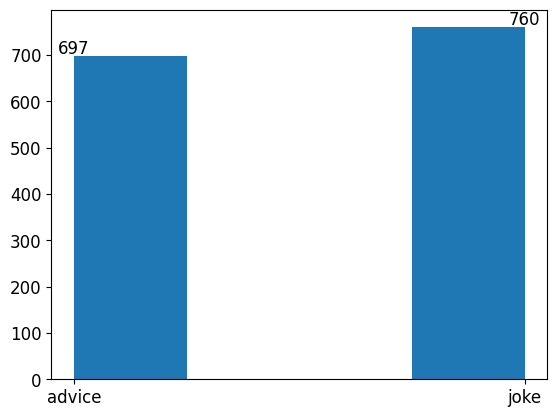

In [35]:
plt.hist(full_df['category'], bins=4, align='mid')
for i in ['advice', 'joke']:
    counts = len(full_df[full_df['category'] == i])
    plt.text(i, counts-3, str(counts), ha = 'center', va = 'bottom')
plt.rc('font', size = 12)
plt.show()

# 2. 데이터 전처리

#### 특수문자 불용어 제거, 소문자 변환

In [36]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s\d]', "", text)
    text = text.lower()
    text = text.split()
    text = [w for w in text if w not in stop_words]
    return " ".join(text)

full_df['text'] = full_df['text'].apply(lambda x: preprocess_text(x))
full_df

,text,category
0,friends family support system tell need hear w...,advice
1,little sincerity dangerous thing great deal ab...,advice
2,thing really hard really amazing giving perfec...,advice
3,rule software systems work well used failed re...,advice
4,technology like art soaring exercise human ima...,advice
...,...,...
755,giraffes slow apologize takes long time swallo...,joke
756,dad im hungry hello hungry im dad,joke
757,im practicing bugeating contest ive got butter...,joke
758,heart lion lifetime ban san diego zoo,joke


#### 데이터 분할

In [38]:
df_train, df_test = train_test_split(full_df, test_size=0.3)

#### 텍스트 토큰화, 레이블 인코딩

(array([224., 431., 140.,  87.,  57.,  43.,  22.,  10.,   3.,   2.]),
 array([ 2. ,  5.6,  9.2, 12.8, 16.4, 20. , 23.6, 27.2, 30.8, 34.4, 38. ]),
 <BarContainer object of 10 artists>)

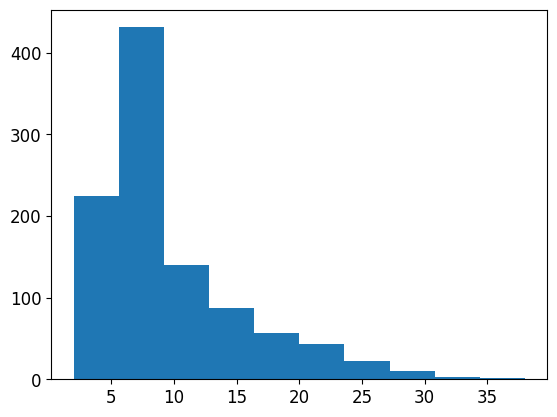

In [39]:
plt.hist([len(text.split()) for text in df_train['text']])

주로 15개 내외의 단어로 이루어진 문장이 많은 것으로 보인다. <p>
데이터 변경 후에는 20대도 많으므로 max_length를 20으로 조정.

In [40]:
# 토큰화
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def bt(text):
    return bert_tokenizer(text, padding= 'max_length', max_length=15, truncation=True)

train_bt = [bt(text) for text in df_train['text']]
test_bt = [bt(text) for text in df_test['text']]

# 목표변수 인코딩
le = LabelEncoder()
le.fit(df_train['category'])
def making_labels(y):
    return pd.DataFrame({'labels' : list(le.transform(y))})


le_train = making_labels(df_train['category'])
le_test = making_labels(df_test['category'])

In [41]:
dict(zip(le.classes_, le.transform(le.classes_)))

{'advice': 0, 'joke': 1}

#### 데이터셋으로 변환

In [42]:
ds_train = Dataset.from_pandas(pd.concat((pd.DataFrame(train_bt), le_train), axis=1), preserve_index=False)
ds_test = Dataset.from_pandas(pd.concat((pd.DataFrame(test_bt), le_test), axis=1), preserve_index=False)

In [43]:
print("학습용 데이터셋 : \n", ds_train)
print("\n 검증용 데이터셋 : \n", ds_test)

학습용 데이터셋 : 
 Dataset({
    features: ['attention_mask', 'input_ids', 'token_type_ids', 'labels'],
    num_rows: 1019
})

 검증용 데이터셋 : 
 Dataset({
    features: ['attention_mask', 'input_ids', 'token_type_ids', 'labels'],
    num_rows: 438
})


# 3. 모델학습

In [44]:
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)

# #평가지표
# def compute_metrix(pred):
#     preds = pred.predictions.argmax(-1)
#     return {"accuracy": accuracy_score(pred.label_ids, preds)}

# #하이퍼 파라미터 목록
# def optuna_hp_space(trial):
#     return {
#         'learning_rate' : trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
#         "per_device_train_batch_size" : trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32, 64]),
#         "per_device_eval_batch_size" : trial.suggest_categorical("per_device_eval_batch_size", [8, 16, 32, 64])
#     }


# def model_trainer(trial):

#     #튜닝할 하이퍼 파라미터


#     #하이퍼 파라미터 설정
#     training_args = TrainingArguments(
#     output_dir="./bert_model",
#     learning_rate=lr,
#     per_device_train_batch_size=pdtbs,
#     per_device_eval_batch_size=pdebs,

#     num_train_epochs=3,
#     evaluation_strategy="steps",
#     save_total_limit=2,
#     eval_steps=100,
#     load_best_model_at_end=True,
#     )

#     #트레이너 설정
#     trainer = Trainer(
#         model = bert_model,
#         args = training_args,
#         train_dataset = ds_train,
#         eval_dataset = ds_test,
#         compute_metrics = compute_metrix
#     )

#     #모델 학습
#     trainer.train()

#     #평가지표 저장
#     metrics = trainer.evaluate()
#     return metrics[['accuracy']] #해석이 용이한 accuracy를 기준으로 학습

# model_study = optuna.create_study(direction='maximize') #값을 최대화하는 방향으로 튜닝 (accuracy는 높아야하므로 maximize)
# model_study.optimize(model_trainer, n_trials = 10)



# best_model = model_study.best_params
# best_score = model_study.best_value

# print("최적 모델 : \n",best_model)
# print("\n 최적 스코어 : \n", best_score)

위 코드에서 다음과 같은 오류가 발생했다. <p>
TypeError: unhashable type: 'list'  <p>
[W 2023-10-17 12:22:36,283] Trial 0 failed with value None.  <p>
해결하진 못 했으나 다른 방법이 있기 때문에 하단의 다른 코드를 사용해 하이퍼파라미터 튜닝을 실시한다.

In [52]:
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)

def model_init(trial):
    return BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)


#평가지표
def compute_metrix(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    class_weights = [1.0, 1.25] # 0: advice, 1: joke
    weight_acc = accuracy_score(labels, preds, sample_weight = [class_weights[label] for label in labels])
    return {"accuracy": weight_acc}

#하이퍼 파라미터 목록
def optuna_hp_space(trial):
    return {
        'learning_rate' : trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True),
        "per_device_train_batch_size" : trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32, 64]),
        "per_device_eval_batch_size" : trial.suggest_categorical("per_device_eval_batch_size", [4, 8, 16, 32, 64])
    }


#하이퍼 파라미터 입력
training_args = TrainingArguments(
    output_dir="./bert_model",
    # learning_rate=learning_rate,
    # per_device_train_batch_size=per_device_train_batch_size,
    # per_device_eval_batch_size=per_device_eval_batch_size,

    num_train_epochs=12,
    evaluation_strategy="steps",
    save_total_limit=2,
    eval_steps=50,
    load_best_model_at_end=True, #데이터 변경 후 변경함. 후에 다시 할때는 True로 바꿀것
)

#트레이너 설정
trainer = Trainer(
    model = None,
    model_init = model_init,
    args = training_args,
    train_dataset = ds_train,
    eval_dataset = ds_test,
    compute_metrics = compute_metrix
)

best_trial = trainer.hyperparameter_search(
    direction = "maximize",
    backend = 'optuna',
    hp_space = optuna_hp_space,
    n_trials = 20,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-21 12:32:03,679] A new study created in memory with name: no-name-962588eb-7c5d-41a9-9765-d1bb0ec6e5ab
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.830821,0.428716
100,No log,1.124254,0.571284
150,No log,0.760358,0.571284
200,No log,0.758281,0.428716
250,No log,0.804578,0.428716
300,No log,0.803235,0.428716
350,No log,0.764427,0.428716
400,No log,0.702671,0.571284
450,No log,0.757941,0.571284
500,0.908500,0.822978,0.571284


[I 2023-10-21 12:33:37,735] Trial 0 finished with value: 0.4287158746208291 and parameters: {'learning_rate': 0.0055540210835167405, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32}. Best is trial 0 with value: 0.4287158746208291.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,1.048864,0.431244
100,No log,0.806136,0.428716
150,No log,0.671054,0.571284
200,No log,0.695056,0.428716
250,No log,0.752460,0.428716
300,No log,0.694331,0.428716
350,No log,0.780496,0.428716
400,No log,0.759465,0.571284
450,No log,0.706076,0.571284
500,0.734100,0.693290,0.571284


[I 2023-10-21 12:39:20,250] Trial 1 finished with value: 0.5712841253791708 and parameters: {'learning_rate': 0.0001848144809533997, 'per_device_train_batch_size': 4, 'per_device_eval_batch_size': 16}. Best is trial 1 with value: 0.5712841253791708.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.698953,0.571284
100,No log,0.705079,0.428716
150,No log,0.825453,0.571284
200,No log,0.896234,0.428716
250,No log,0.725761,0.428716
300,No log,0.713562,0.571284
350,No log,0.697663,0.571284


[I 2023-10-21 12:40:12,914] Trial 2 finished with value: 0.5712841253791708 and parameters: {'learning_rate': 0.005379191927575034, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 16}. Best is trial 1 with value: 0.5712841253791708.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.684093,0.622346
100,No log,0.703874,0.428716
150,No log,0.694635,0.428716
200,No log,0.704675,0.571284
250,No log,0.827000,0.571284
300,No log,0.692754,0.571284
350,No log,0.753205,0.428716
400,No log,0.697851,0.571284
450,No log,0.717830,0.428716
500,0.730300,0.751334,0.571284


[I 2023-10-21 12:41:57,779] Trial 3 finished with value: 0.4287158746208291 and parameters: {'learning_rate': 0.0011678113846351143, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 4}. Best is trial 1 with value: 0.5712841253791708.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.366172,0.876138
100,No log,0.575059,0.725986
150,No log,0.510378,0.805865
200,No log,0.636796,0.626390
250,No log,0.411828,0.861982
300,No log,0.521273,0.899393
350,No log,0.502580,0.899393
400,No log,0.398720,0.886249
450,No log,0.466847,0.895349
500,0.533700,0.349442,0.895854


[I 2023-10-21 12:48:38,567] Trial 4 finished with value: 0.5712841253791708 and parameters: {'learning_rate': 0.00011749586618500617, 'per_device_train_batch_size': 4, 'per_device_eval_batch_size': 4}. Best is trial 1 with value: 0.5712841253791708.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.695548,0.571284
100,No log,0.701630,0.428716
150,No log,0.758294,0.428716
200,No log,0.819368,0.428716
250,No log,0.694638,0.428716
300,No log,0.696185,0.571284
350,No log,0.704104,0.571284


[I 2023-10-21 12:49:40,017] Trial 5 finished with value: 0.5712841253791708 and parameters: {'learning_rate': 0.0064469018346047045, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 4}. Best is trial 1 with value: 0.5712841253791708.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.708141,0.428716


[I 2023-10-21 12:49:46,396] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.721136,0.428716


[I 2023-10-21 12:50:00,639] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.701749,0.571284
100,No log,0.692683,0.571284
150,No log,0.699387,0.571284


[I 2023-10-21 12:50:44,908] Trial 8 finished with value: 0.5712841253791708 and parameters: {'learning_rate': 0.001521782660239175, 'per_device_train_batch_size': 64, 'per_device_eval_batch_size': 8}. Best is trial 1 with value: 0.5712841253791708.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.243410,0.914560
100,No log,0.493272,0.910010
150,No log,0.421518,0.932760
200,No log,0.550178,0.919110
250,No log,0.525975,0.923660
300,No log,0.536387,0.921638
350,No log,0.542582,0.921638


[I 2023-10-21 12:51:37,307] Trial 9 finished with value: 0.9216380182002022 and parameters: {'learning_rate': 4.293031986019314e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32}. Best is trial 9 with value: 0.9216380182002022.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.258067,0.898888
100,No log,0.293678,0.911527
150,No log,0.411936,0.919616
200,No log,0.478604,0.924671
250,No log,0.482078,0.932760
300,No log,0.493614,0.927705
350,No log,0.495828,0.927705


[I 2023-10-21 12:52:29,591] Trial 10 finished with value: 0.9277047522750252 and parameters: {'learning_rate': 2.006496920169984e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32}. Best is trial 10 with value: 0.9277047522750252.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.279587,0.893832
100,No log,0.279338,0.913549
150,No log,0.360951,0.931244
200,No log,0.373648,0.912538
250,No log,0.430251,0.915066
300,No log,0.460556,0.917594
350,No log,0.470913,0.912538


[I 2023-10-21 12:53:21,534] Trial 11 finished with value: 0.9125379170879676 and parameters: {'learning_rate': 1.747106344473912e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32}. Best is trial 10 with value: 0.9277047522750252.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.333077,0.895854
100,No log,0.248026,0.906977
150,No log,0.317493,0.906977
200,No log,0.361984,0.915571
250,No log,0.393549,0.901416
300,No log,0.416611,0.914560
350,No log,0.431696,0.912538


[I 2023-10-21 12:54:13,447] Trial 12 finished with value: 0.9125379170879676 and parameters: {'learning_rate': 1.2816322922646813e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32}. Best is trial 10 with value: 0.9277047522750252.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.248010,0.923155
100,No log,0.451753,0.911527
150,No log,0.427756,0.926188
200,No log,0.498389,0.925683
250,No log,0.513428,0.914560
300,No log,0.512569,0.916077
350,No log,0.522491,0.916077


[I 2023-10-21 12:55:06,338] Trial 13 finished with value: 0.916076845298281 and parameters: {'learning_rate': 4.085198549140344e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32}. Best is trial 10 with value: 0.9277047522750252.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.306340,0.889788
100,No log,0.229661,0.927705
150,No log,0.237094,0.922144
200,No log,0.395498,0.919110
250,No log,0.403474,0.913549
300,No log,0.346033,0.924166
350,No log,0.336286,0.939838
400,No log,0.513670,0.915066
450,No log,0.431931,0.925683
500,0.188200,0.462948,0.926188


[I 2023-10-21 12:57:50,608] Trial 14 finished with value: 0.9241658240647118 and parameters: {'learning_rate': 4.7342389637695096e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 32}. Best is trial 10 with value: 0.9277047522750252.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.283644,0.908493
100,No log,0.242298,0.914055
150,No log,0.375756,0.899393
200,No log,0.445355,0.904954
250,No log,0.324761,0.920121
300,No log,0.495636,0.917088
350,No log,0.461160,0.924166
400,No log,0.446876,0.928210
450,No log,0.539168,0.917088
500,0.195800,0.511992,0.927705


[I 2023-10-21 13:00:38,208] Trial 15 finished with value: 0.9312436804853387 and parameters: {'learning_rate': 4.644981822789779e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 64}. Best is trial 15 with value: 0.9312436804853387.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.528043,0.882710


[I 2023-10-21 13:00:43,982] Trial 16 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.692904,0.571284


[I 2023-10-21 13:00:50,041] Trial 17 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.317561,0.889282
100,No log,0.279572,0.911021
150,No log,0.373326,0.915066
200,No log,0.327738,0.929221
250,No log,0.386335,0.921638
300,No log,0.534233,0.895854
350,No log,0.443846,0.910516
400,No log,0.439962,0.912538
450,No log,0.345010,0.929727
500,0.268200,0.320165,0.922144


[I 2023-10-21 13:03:39,481] Trial 18 finished with value: 0.9398382204246714 and parameters: {'learning_rate': 7.361580217705999e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 64}. Best is trial 18 with value: 0.9398382204246714.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.336180,0.876138


[I 2023-10-21 13:03:45,748] Trial 19 pruned. 


In [53]:
best_trial

BestRun(run_id='18', objective=0.9398382204246714, hyperparameters={'learning_rate': 7.361580217705999e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 64}, run_summary=None)

1차 : 정확도가 약 0.929로 높게 나타났다. 이 모델을 이용해 다른 농담과 명언이 주어졌을 때 어떻게 분류할 지 확인할 수 있다.

# 4. 새로운 데이터 예측

In [54]:
best_hp = best_trial.hyperparameters
best_model = model_init(best_hp)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


새로운 api에서 유사한 데이터를 받아 동일한 전처리를 한 후 모델에 적용시킨다.

In [55]:
#농담
new_api_url_j = 'https://official-joke-api.appspot.com/random_ten'
new_response_j = requests.get(new_api_url_j)
new_joke_json = new_response_j.json()
joke_new = [i['setup'] + " " + i['punchline'] for i in new_joke_json]
joke_new_df = pd.DataFrame({'text' : joke_new, 'category' : ['joke' for _ in list(range(len(joke_new)))]})

#명언
num = random.randint(1,38)
new_api_url_q = 'https://quote-garden.onrender.com/api/v3/quotes/?page=' + f'{num}'
new_response_q = requests.get(new_api_url_q)
new_quote_json = new_response_q.json()
quote_new = [i['quoteText'] for i in new_quote_json['data']]
quote_new_df = pd.DataFrame({'text' : quote_new, 'category' : ['advice' for _ in list(range(len(quote_new)))]})

new_df = pd.concat((joke_new_df, quote_new_df), axis = 0)

new_df['text'] = new_df['text'].apply(lambda x: preprocess_text(x))

new_bt = [bt(text) for text in new_df['text']]
new_le = making_labels(new_df['category'])

ds_new = Dataset.from_pandas(pd.concat((pd.DataFrame(new_bt), new_le), axis = 1), preserve_index=False)

In [56]:
new_pred = Trainer(model = best_model).predict(ds_new)

In [57]:
new_logits = torch.tensor(new_pred.predictions)
new_preds = new_logits.argmax(-1)

In [58]:
print('예측 : ', new_preds)
print('예측 정확도 : ', accuracy_score(new_preds, ds_new['labels']))

예측 :  tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
예측 정확도 :  0.65


1차 : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) <p>
주로 joke로 많이 예측하는 것을 알 수 있다. 이는 학습된 데이터가 joke가 더 많은 불균형이 있어 advice에 그만큼 가중치를 부여할 필요가 있다고 판단되었다.

2차 : tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) <p>
데이터 추가 후에는 오히려 모두 advice로 분류하고 있다.